<a href="https://colab.research.google.com/github/preonxtrun/SOC/blob/main/SemSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -q
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -q

!tar -xzf images.tar.gz
!tar -xzf annotations.tar.gz

print("✅ Dataset downloaded and extracted successfully!")

✅ Dataset downloaded and extracted successfully!


In [2]:
import os
import torch
import numpy as np
from PIL import Image
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt


In [3]:

LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 8
NUM_WORKERS = 2
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
PIN_MEMORY = True

TRAIN_IMG_DIR = "/content/images/"
TRAIN_MASK_DIR = "/content/annotations/trimaps/"



In [4]:

class PetDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, image_list=None):
        super(PetDataset, self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = image_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        image_path = os.path.join(self.image_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        binary_mask = np.where(mask == 1, 1.0, 0.0).astype(np.float32)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=binary_mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

def get_data_loaders(train_transform, val_transform):
    all_images = sorted([f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('.jpg')])

    split_idx = int(len(all_images) * 0.9)
    train_images = all_images[:split_idx]
    val_images = all_images[split_idx:]

    train_ds = PetDataset(
        image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_MASK_DIR,
        transform=train_transform, image_list=train_images
    )
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY, shuffle=True,
    )

    val_ds = PetDataset(
        image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_MASK_DIR,
        transform=val_transform, image_list=val_images
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY, shuffle=False,
    )

    return train_loader, val_loader


In [5]:


train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=35, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.2),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

class ResNet_Backbone(nn.Module):
    def __init__(self, output_layer=None):
        super(ResNet_Backbone, self).__init__()
        self.pretrained = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1, len(self.layers) - self.layer_count):
            self.pretrained._modules.pop(self.layers[-i])

        self.net = nn.Sequential(*self.pretrained._modules.values())
        self.pretrained = None

    def forward(self, x):
        return self.net(x)

class Atrous_Convolution(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, pad, dilation_rate):
        super(Atrous_Convolution, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, padding=pad, dilation=dilation_rate, bias=False)
        self.batchnorm = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        rates = [6, 12, 18]
        self.conv_1x1 = Atrous_Convolution(in_channels, out_channels, 1, 0, 1)
        self.conv_3x3_r6 = Atrous_Convolution(in_channels, out_channels, 3, rates[0], rates[0])
        self.conv_3x3_r12 = Atrous_Convolution(in_channels, out_channels, 3, rates[1], rates[1])
        self.conv_3x3_r18 = Atrous_Convolution(in_channels, out_channels, 3, rates[2], rates[2])
        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
        self.final_conv = Atrous_Convolution(out_channels * 5, out_channels, 1, 0, 1)

    def forward(self, x):
        x1 = self.conv_1x1(x)
        x2 = self.conv_3x3_r6(x)
        x3 = self.conv_3x3_r12(x)
        x4 = self.conv_3x3_r18(x)
        x5 = self.image_pool(x)
        x5_upsampled = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        return self.final_conv(torch.cat((x1, x2, x3, x4, x5_upsampled), dim=1))

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()
        self.backbone = ResNet_Backbone(output_layer='layer3')
        self.aspp = ASPP(in_channels=1024, out_channels=256)
        self.low_level_features_extractor = ResNet_Backbone(output_layer='layer1')
        self.low_level_conv = Atrous_Convolution(256, 48, 1, 0, 1)
        self.decoder_conv = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True)
        )
        self.classifier = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        high_level_features = self.backbone(x)
        aspp_features = self.aspp(high_level_features)
        low_level_features = self.low_level_features_extractor(x)
        low_level_features = self.low_level_conv(low_level_features)
        aspp_upsampled = F.interpolate(aspp_features, size=low_level_features.shape[2:], mode='bilinear', align_corners=True)
        concat_features = torch.cat([low_level_features, aspp_upsampled], dim=1)
        decoder_output = self.decoder_conv(concat_features)
        final_upsample = F.interpolate(decoder_output, size=x.shape[2:], mode='bilinear', align_corners=True)
        return self.classifier(final_upsample)


In [6]:


class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        bce = self.bce_loss(inputs, targets)
        inputs_sigmoid = torch.sigmoid(inputs)
        inputs_flat, targets_flat = inputs_sigmoid.view(-1), targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        return bce + dice_loss

def save_checkpoint(state, filename="deeplabv3plus_pets.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def check_accuracy(loader, model, device="cuda"):
    num_correct, num_pixels, dice_score = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    accuracy = num_correct / num_pixels * 100
    avg_dice_score = dice_score / len(loader)
    print(f"\nValidation Accuracy: {accuracy:.2f}%")
    print(f"Validation Dice Score: {avg_dice_score:.4f}")
    model.train()
    return avg_dice_score

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader, leave=True)
    for data, targets in loop:
        data, targets = data.to(device=DEVICE), targets.float().unsqueeze(1).to(device=DEVICE)
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss=loss.item())


In [7]:


def main():
    print(f"Starting training on device: {DEVICE}")
    model = DeepLabV3Plus(num_classes=1).to(DEVICE)
    loss_fn = DiceBCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()
    train_loader, val_loader = get_data_loaders(train_transform, val_transform)

    best_dice = -1.0
    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        current_dice = check_accuracy(val_loader, model, device=DEVICE)
        if current_dice > best_dice:
            best_dice = current_dice
            save_checkpoint({"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()})

if __name__ == "__main__":
    main()

🐶 Starting training on device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]
/tmp/ipython-input-935131668.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



--- Epoch 1/8 ---


  0%|          | 0/416 [00:00<?, ?it/s]/tmp/ipython-input-2358608506.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 416/416 [01:16<00:00,  5.46it/s, loss=0.251]



Validation Accuracy: 95.84%
Validation Dice Score: 0.9208
=> Saving checkpoint

--- Epoch 2/8 ---


100%|██████████| 416/416 [01:13<00:00,  5.63it/s, loss=0.176]



Validation Accuracy: 96.18%
Validation Dice Score: 0.9289
=> Saving checkpoint

--- Epoch 3/8 ---


100%|██████████| 416/416 [01:14<00:00,  5.61it/s, loss=0.199]



Validation Accuracy: 96.55%
Validation Dice Score: 0.9354
=> Saving checkpoint

--- Epoch 4/8 ---


100%|██████████| 416/416 [01:14<00:00,  5.60it/s, loss=0.131]



Validation Accuracy: 96.39%
Validation Dice Score: 0.9333

--- Epoch 5/8 ---


100%|██████████| 416/416 [01:14<00:00,  5.59it/s, loss=0.246]



Validation Accuracy: 96.49%
Validation Dice Score: 0.9340

--- Epoch 6/8 ---


100%|██████████| 416/416 [01:14<00:00,  5.60it/s, loss=0.214]



Validation Accuracy: 96.63%
Validation Dice Score: 0.9369
=> Saving checkpoint

--- Epoch 7/8 ---


100%|██████████| 416/416 [01:14<00:00,  5.59it/s, loss=0.113]



Validation Accuracy: 96.52%
Validation Dice Score: 0.9357

--- Epoch 8/8 ---


100%|██████████| 416/416 [01:14<00:00,  5.57it/s, loss=0.137]



Validation Accuracy: 96.47%
Validation Dice Score: 0.9343


Loading saved checkpoint...


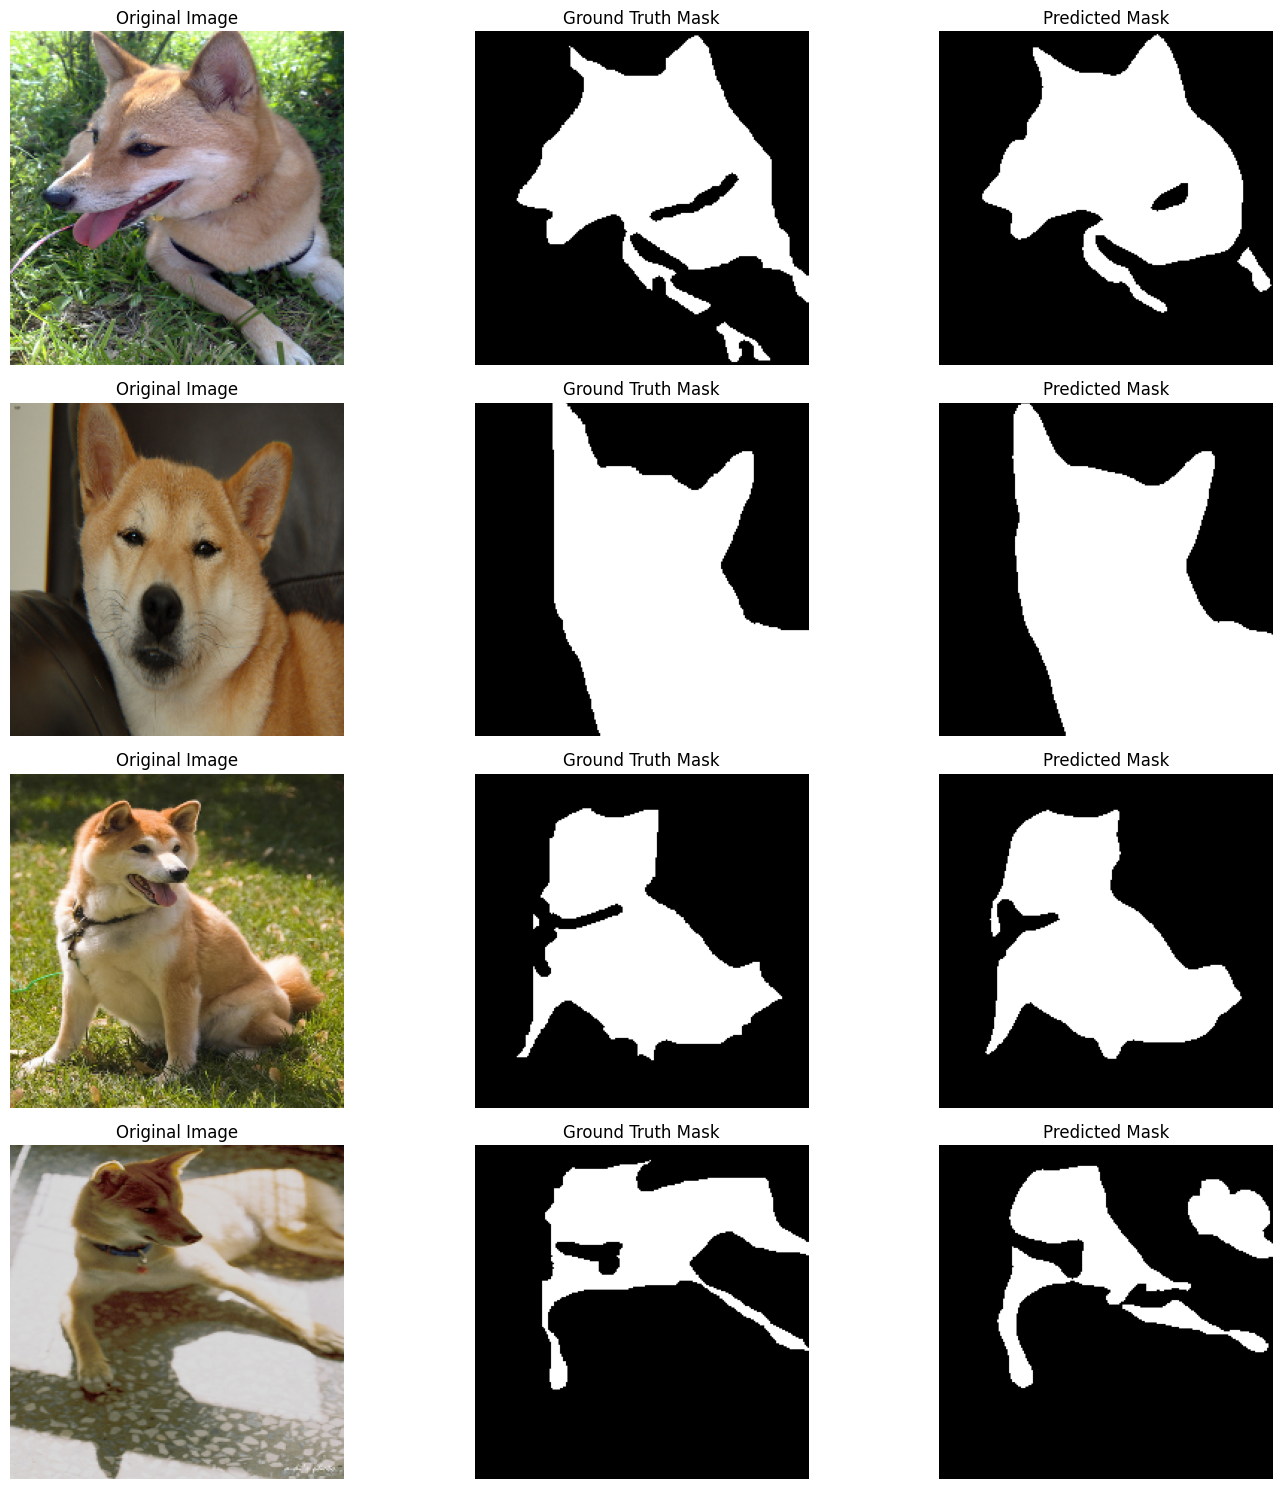

In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions(model, loader, device="cuda"):
    model.eval()
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        preds = torch.sigmoid(model(images))
        preds = (preds > 0.5).float()

    images_cpu = images.cpu().numpy()
    masks_cpu = masks.cpu().numpy()
    preds_cpu = preds.cpu().numpy()

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(15, 15))
    for i in range(min(5, len(images))):

        img = images_cpu[i].transpose(1, 2, 0) # From (C, H, W) to (H, W, C)
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.subplot(4, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(4, 3, i * 3 + 2)
        plt.imshow(masks_cpu[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(4, 3, i * 3 + 3)
        plt.imshow(preds_cpu[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    model.train()

_, val_loader = get_data_loaders(train_transform, val_transform)
model = DeepLabV3Plus(num_classes=1).to(DEVICE)


print("Loading saved checkpoint...")
checkpoint_path = "deeplabv3plus_pets.pth.tar"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])


    visualize_predictions(model, val_loader, device=DEVICE)
else:
    print(f"Checkpoint file not found at '{checkpoint_path}'. Please train the model first.")